In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

Then, we simulate dipole sources

In [3]:
sourcers1 = 70
sourcers2 = 30
np.random.seed(5)

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2), [ 500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, sourcers1+sourcers2), [-15, -15, -30]]),  # µm
)
dipole_moments = mg.angles_to_vector(
    inclination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(0, 10, sourcers2), [10, -10, -5]]),
    declination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(180, 10, sourcers2), [10, 170, 190]]),
    amplitude=np.concatenate([abs(np.random.normal(0, 100, sourcers1+sourcers2))*1.0E-14, [5e-11, 5e-11, 5e-11]]),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print()

In [4]:
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 -4.643 -4.693 -4.744 ... 0.004321 -0.02257 -0.04858

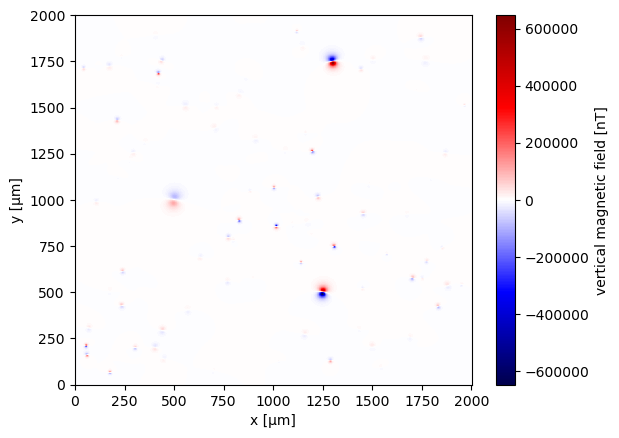

In [5]:
data.bz.plot.pcolormesh(cmap="seismic")#, vmax=5000, vmin=-5000)

In [6]:
noise_std_dev = 20  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)

In [7]:
data.bz.values += 250

original_data = data.copy(deep=True)
data_copy = data.copy(deep=True)

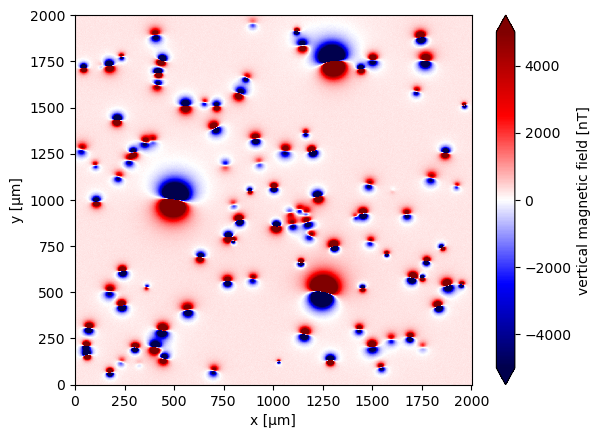

In [8]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)

# Anomaly detection


First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [9]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 248.5 248.4 248.6 248.5 ... 249.5 249.0 248.8 248.8

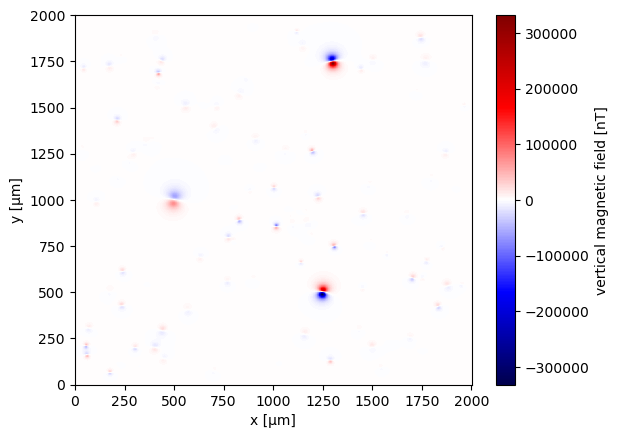

In [10]:
data_up.bz.plot.pcolormesh(cmap="seismic")#, vmax=50000, vmin=-50000)

## 2. Calculate the TGA


We do this with finite difference derivatives to avoid amplifying noise.

In [11]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 248.5 248.4 248.6 248.5 ... 249.5 249.0 248.8 248.8
    tga      (y, x) float64 0.3047 0.4795 0.6313 0.5569 ... 0.5029 0.3355 0.1979
    x_deriv  (y, x) float64 -0.03637 0.02616 0.0165 ... -0.06481 -0.02953
    y_deriv  (y, x) float64 -0.1386 -0.4448 -0.601 ... 0.3129 0.2288 0.02653
    z_deriv  (y, x) float64 0.2689 0.1773 -0.1926 ... 0.3597 0.2366 0.1939

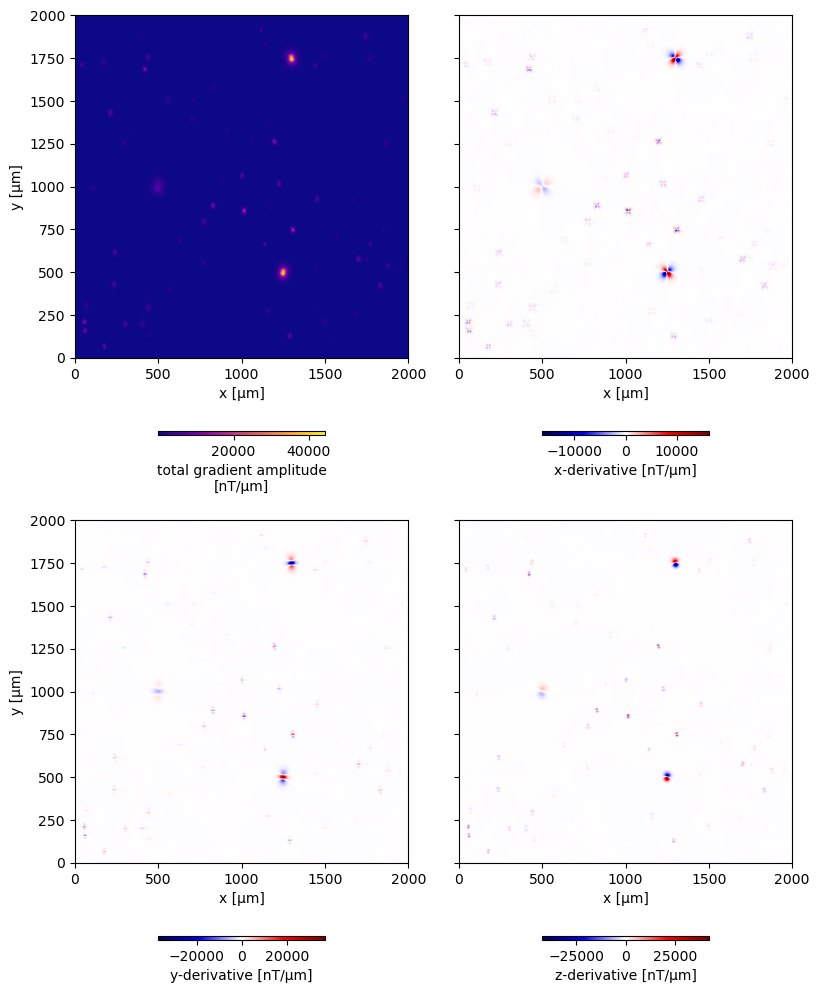

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [13]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

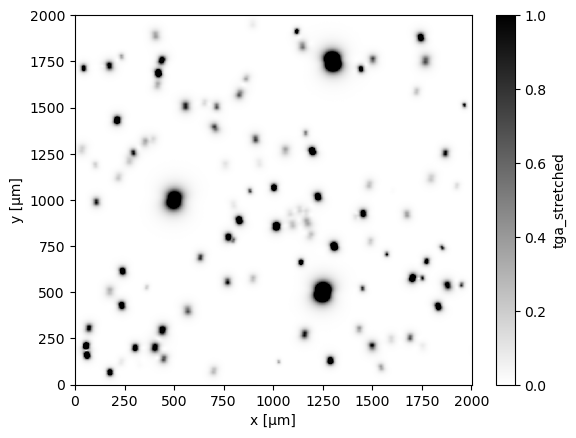

In [14]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [15]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 150],
    size_increment=1.0,
    threshold=0.01,
    overlap=0.3,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [16]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

99 potential sources detected within 6.2252 seconds


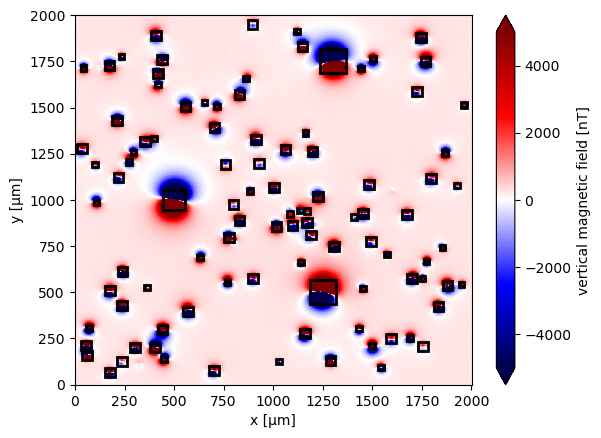

In [17]:
ax = plt.subplot(111)
# data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="seismic")
data.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmax=5000, vmin=-5000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [18]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#     bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [19]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

99 euler positions and dipole moments estimated within 1.5953 seconds


Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [20]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

In [21]:
data_cut = data.copy(deep=True)
data_cut

<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 251.5 224.5 260.3 264.0 ... 248.2 223.1 243.2 237.9

In [22]:
# data_cut = data_copy.where(data_copy['bz'].isnull())
data_cut = data_copy.where(data_copy['bz'].isnull(), 0)
data_cut

<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [23]:
# Display the actual data used in the interf. sources inversion
for window in (np.array(windows_filtered)):
    window_data = original_data.bz.sel(x=slice(*window[:2]), y=slice(*window[2:])).values

    data_cut.bz.sel(x=slice(*window[:2]), y=slice(*window[2:])).values += window_data

# data_cut = data_cut.where(data_copy['bz'] == 0, np.nan)
data_cut

<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [24]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

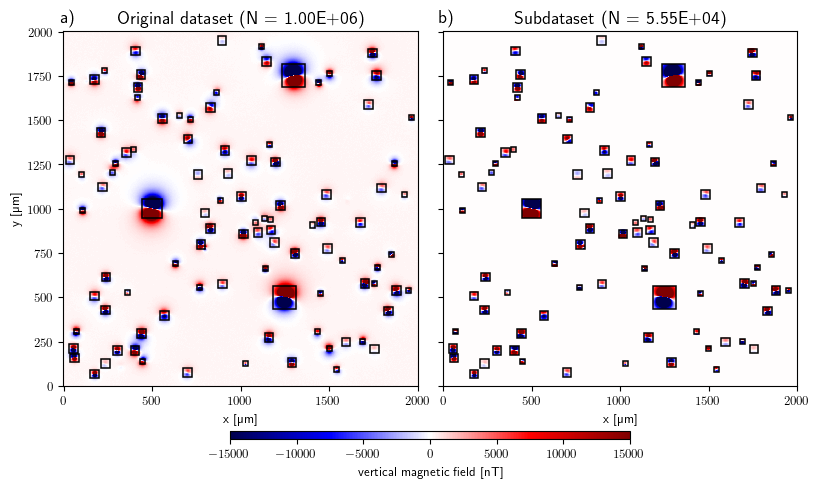

In [25]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

    axes = axes.ravel()

    ax = axes[0]
    tmp1 = data['bz'].plot.pcolormesh(ax=ax, cmap='seismic', 
                                      add_colorbar=False, vmin=-15000, vmax=15000)
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)



    ax = axes[1]
    tmp2 = data_cut['bz'].plot.pcolormesh(ax=ax, cmap='seismic', 
                                          add_colorbar=False, vmin=-15000, vmax=15000)

    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)
    
    # the compressed dataset
    fil = data_cut.bz.values != 0
    
    titles = ([f' Original dataset (N = {np.size(data.bz):.2E})',
               f' Subdataset (N = {np.size(data_cut.bz.values[fil]):.2E})'
                ])
    
    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_title(title, fontsize=13)
        ax.set_aspect("equal")

    axes[1].set_ylabel('')
    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)

    fig.colorbar(tmp2, **cbar_kwargs, label="vertical magnetic field [nT]",
                 cax=fig.add_axes([0.275, -0.055, 0.5, 0.02]))

    fig.savefig(fig_dir / "methodology.png", dpi=300, facecolor='w', bbox_inches='tight')

plt.show()

In [26]:
print(np.size(data.bz))

fil = data_cut.bz.values != 0
print(np.size(data_cut.bz.values[fil]))

1002001
55475
